# First source extraction

This is the pipeline for initial source extraction from the motion-corrected memmap file.

It loads the memmap file in the provided root directory, performs CaImAns source extraction based on the given parameters, calculates the local correlation image which is used as a background for the session, saves a plot of all component contours and saves the CNM object in the root directory.


In [1]:
# Import packages
import sys
sys.path.append('../custom scripts/')

from caiman.source_extraction import cnmf
import standard_pipeline.place_cell_pipeline as pipe
import standard_pipeline.behavior_import as behavior
import caiman as cm
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

# Start cluster for parallel processing
c, dview, n_processes = cm.cluster.setup_cluster(backend='local', n_processes=None, single_thread=False)

Using TensorFlow backend.


## Source extraction

### Define parameters

First, we have to define the root directory and source extraction parameters.

In [2]:
# dataset dependent parameters
root = r'W:\Neurophysiology-Storage1\Wahl\Hendrik\PhD\Data\Batch3\M39\20200827'

fr = 30  # imaging rate in frames per second
decay_time = 0.4  # length of a typical transient in seconds (0.4)
dxy = (1.66, 1.52)  # spatial resolution (um per pixel) [(1.66, 1.52) for 1x, (0.83, 0.76) for 2x]

# extraction parameters
p = 1  # order of the autoregressive system
gnb = 2  # number of global background components (3)
merge_thr = 0.75  # merging threshold, max correlation allowed (0.86)
rf = 25  # half-size of the patches in pixels. e.g., if rf=25, patches are 50x50
stride_cnmf = 10  # amount of overlap between the patches in pixels (20)
K = 23  # number of components per patch (10)
gSig = [5, 5]  # expected half-size of neurons in pixels [X, Y] (has to be int, not float!)
method_init = 'greedy_roi'  # initialization method (if analyzing dendritic data using 'sparse_nmf')
ssub = 2  # spatial subsampling during initialization
tsub = 2  # temporal subsampling during intialization

opts_dict = {'fnames': None,
             'fr': fr,
             'decay_time': decay_time,
             'dxy': dxy,
             'nb': gnb,
             'rf': rf,
             'K': K,
             'gSig': gSig,
             'stride': stride_cnmf,
             'method_init': method_init,
             'rolling_sum': True,
             'merge_thr': merge_thr,
             'only_init': True,
             'ssub': ssub,
             'tsub': tsub}

cnm_params = cnmf.params.CNMFParams(params_dict=opts_dict)


In [ ]:
root = r'W:\Neurophysiology-Storage1\Wahl\Hendrik\PhD\Data\Batch3\M41\20200513'
pipe.load_cnmf(root).params

### Source extraction

Now we can perform the real source extraction. For this we...<br>
1. ...load the motion-corrected memmap file,<br>
2. ...run CaImAns source extraction function,<br>
3. ...calculate the local correlation image of the session which is used as a reference image,<br>
4. ...plot the contours of all detected components for later inspection.<br>

We also save the results in a CNM object after every step so that we dont loose data after an error occurs.

Loading file W:\Neurophysiology-Storage1\Wahl\Hendrik\PhD\Data\Batch3\M39\20200827\memmap__d1_512_d2_472_d3_1_order_C_frames_33784_.mmap...


C:\Anaconda3\envs\caiman\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\Anaconda3\envs\caiman\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


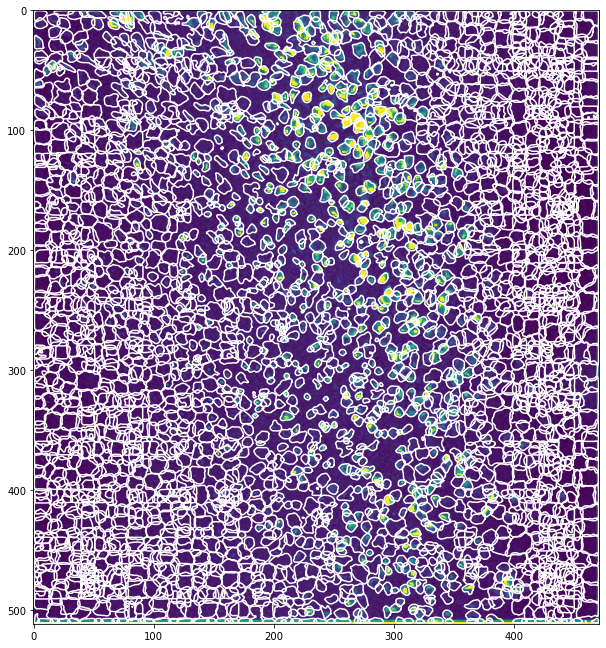

In [3]:
# Load memmap file
mmap_file, images = pipe.load_mmap(root)
# cnm_params = cnm_params.change_params({'fnames': mmap_file})

# # Run source extraction
cnm = pipe.run_source_extraction(images, cnm_params, dview=dview)
pipe.save_cnmf(cnm, path=os.path.join(root, 'cnm_pre_selection.hdf5'), verbose=False, overwrite=True)

# Load local correlation image (should have been created during motion correction)
try:
    cnm.estimates.Cn = io.imread(root + r'\local_correlation_image.tif')
except FileNotFoundError:
    pipe.save_local_correlation(images, root)
    cnm.estimates.Cn = io.imread(root + r'\local_correlation_image.tif')
pipe.save_cnmf(cnm, path=os.path.join(root, 'cnm_pre_selection.hdf5'), verbose=False, overwrite=True)

# Plot and save contours of all components
cnm.estimates.plot_contours(img=cnm.estimates.Cn, display_numbers=False)
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches((10, 10))
plt.savefig(os.path.join(root, 'pre_sel_components.png'))
pipe.save_cnmf(cnm, path=os.path.join(root, 'cnm_pre_selection.hdf5'), verbose=False, overwrite=True)

In [ ]:
pipe.save_cnmf(cnm, path=os.path.join(root, 'cnm_pre_selection.hdf5'), verbose=False, overwrite=True)
del mmap_file

In [ ]:
%matplotlib qt
cnm.estimates.plot_contours(img=cnm.estimates.Cn, display_numbers=False)

### Done!

If the initial extraction looks good, you can continue to the evaluation in the [component evaluation](.//Component_evaluation.ipynb) notebook.
Otherwise just run the extraction again with different parameters.